In [2]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
# Import R libraries
.libPaths("/spin1/users/fearjm/miniconda3/envs/larval_gonad/lib/R/library")
library(Seurat)
library(dplyr)
library(Matrix)

In [8]:
%%R -o meta_data
# Load the testis dataset
testis.data = Read10X(data.dir="../../output/testis1/outs/filtered_gene_bc_matrices/dm6.16")

# Load FBgn to Symbol map
fbgn.symbol = read.table('/data/LCDB/lcdb-references/dmel/r6-11/fb_annotation/dmel_r6-11.fb_annotation', 
                         sep='\t', quote="", header=TRUE, stringsAsFactors=FALSE)
fbgn.symbol = fbgn.symbol[c("primary_FBgn", "gene_symbol")]
colnames(fbgn.symbol) = c('FBgn', 'symbol')
rownames(fbgn.symbol) = fbgn.symbol$FBgn

# Get list of FBgns in both
mask = rownames(fbgn.symbol) %in% rownames(testis.data)
fbgns = fbgn.symbol[mask, c("FBgn")]

# Subset testis with only the FBgns we know
testis.data = testis.data[fbgns, ]

# Change rownames to use symbols
rownames(testis.data) = fbgn.symbol[fbgns, "symbol"]

# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at least 200 detected genes
testis = CreateSeuratObject(raw.data = testis.data, min.cells = 3, min.genes = 200, project = "10X_testis")
nCells = dim(testis@meta.data)[1]
meta_data = testis@meta.data

In [9]:
# Plot distribution of gene counts and UMI counts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
sns.violinplot(y=meta_data.nGene, ax=ax1, inner=None)
sns.stripplot(y=meta_data.nGene, color='k', ax=ax1, jitter=1.02, size=3, alpha=.8)
sns.violinplot(y=meta_data.nUMI, ax=ax2, inner=None)
sns.stripplot(y=meta_data.nUMI, ax=ax2, color='k', jitter=1.02, size=3, alpha=.8)
sns.regplot('nUMI', 'nGene', meta_data, ax=ax3, color='k', scatter_kws={'s': 3})

ax1.set_title('nGene')
ax2.set_title('nUMI')
r2 = stats.pearsonr(meta_data.nGene, meta_data.nUMI)[0]
ax3.set_title(np.round(r2, 2))
plt.tight_layout()

In [10]:
sns.jointplot('nGene', 'nUMI', data=meta_data, kind='reg');

### QC and selecting cells for further analysis

In [12]:
%%R
# We filter out cells that have unique gene counts over 2,500 or less than 200
# Note that low.thresholds and high.thresholds are used to define a 'gate'
# -Inf and Inf should be used if you don't want a lower or upper threshold.
testis = FilterCells(object=testis, subset.names=c("nGene"), 
                     low.thresholds=c(200), high.thresholds=c(6000))

nCells_filter = dim(testis@meta.data)[1]

### Normalizing the data

In [13]:
%%R -o dispersion
testis = NormalizeData(object=testis, normalization.method="LogNormalize", 
                       scale.factor=1e4)

### Detection of variable genes across the single cells
testis = FindVariableGenes(object=testis, 
                           mean.function=ExpMean, 
                           dispersion.function=LogVMR, 
                           x.low.cutoff=0.01, 
                           x.high.cutoff=3, 
                           y.cutoff=0.5,
                           y.high.cutoff=Inf,
                           do.plot=FALSE
                          )

dispersion = testis@hvg.info

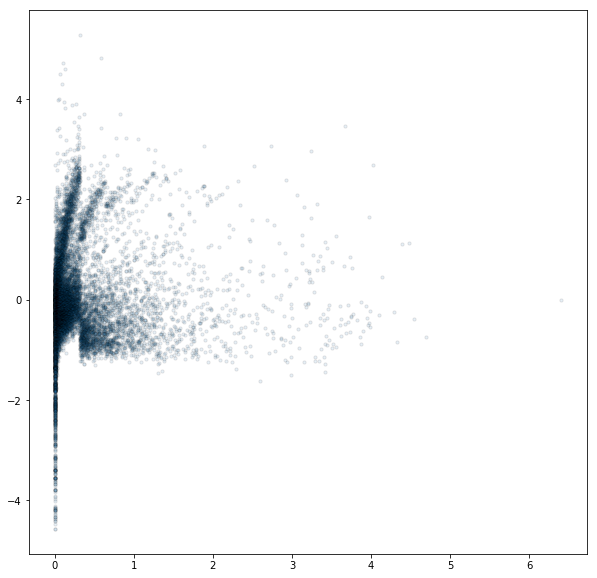

In [14]:
fig = plt.figure(figsize=(10,10))
plt.scatter(dispersion['gene.mean'], dispersion['gene.dispersion.scaled'], 
            s=10, alpha=.1, edgecolor='k')

In [85]:
%%R
print(length(x=testis@var.genes))

### Scaling the data and removing unwanted sources of variation
testis = ScaleData(object=testis, vars.to.regress=c("nUMI"))

### Perform linear dimensional reduction
testis = RunPCA(object=testis, pc.genes=testis@var.genes, do.print=TRUE, 
                pcs.print=1:5, genes.print=5, pcs.compute=100)

# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
testis = ProjectPCA(object=testis, do.print=FALSE)

[1] 2586
[1] "Regressing out nUMI"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%
[1] "PC1"
[1] "CG31909" "CG43922" "COX4L"   "CR44455" "soti"   
[1] ""
[1] "Act5C" "Bacc"  "cib"   "hdc"   "COX5B"
[1] ""
[1] ""
[1] "PC2"
[1] "CG4415"  "CG9123"  "CG12477" "RpL37b"  "blanks" 
[1] ""
[1] "mgl"      "CG42394"  "CG34417"  "Atpalpha" "vir-1"   
[1] ""
[1] ""
[1] "PC3"
[1] "br"     "robo2"  "zfh1"   "Msp300" "abd-A" 
[1] ""
[1] "UQCR-6.4" "COX5B"    "CR43461"  "CG15728"  "GstE6"   
[1] ""
[1] ""
[1] "PC4"
[1] "CG34253" "CG33494" "Npc2a"   "Tep2"    "Cg25C"  
[1] ""
[1] "CG42342"      "retn"         "Abd-B"        "stl"          "E(spl)m2-BFM"
[1] ""
[1] ""
[1] "PC5"
[1] "CG9925"  "vas"     "CG15599" "aub"     "SkpE"   
[1] ""
[1] "CG11700" "CR43260" "CG14810" "CG18518" "CR33222"
[1] ""
[1] ""


In [33]:
%%R -o pca_res -o gene_loadings
pca_res = as.data.frame(testis@dr$pca@cell.embeddings)
gene_loadings = as.data.frame(testis@dr$pca@gene.loadings)

In [81]:
pc1 = gene_loadings.PC1.sort_values(ascending=False).head(30).reset_index()
pc2 = (gene_loadings.PC2 * -1).sort_values(ascending=False).head(30).reset_index()

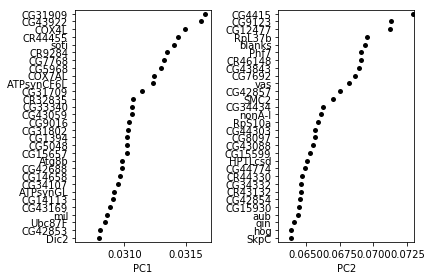

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.stripplot(x="PC1", y="index", data=pc1, ax=ax1, color='k')
ax1.set_xlim(0.0306, 0.0317)
ax1.set_ylabel('')

sns.stripplot(x="PC2", y="index", data=pc2, ax=ax2, color='k')
ax2.set_xlim(0.063, 0.073)
ax2.set_ylabel('')
plt.tight_layout()

Text(0,0.5,'PC2')

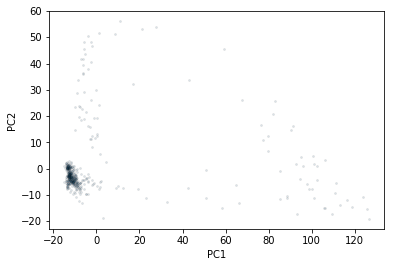

In [34]:
fig, ax = plt.subplots(1, 1)
ax.scatter(pca_res.PC1, -1 * pca_res.PC2, alpha=.1, s=3, edgecolor='k')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

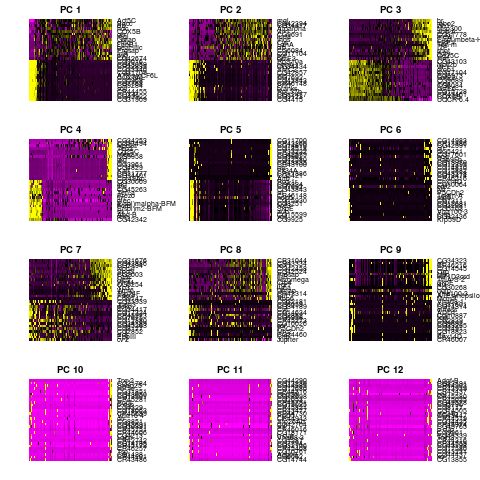

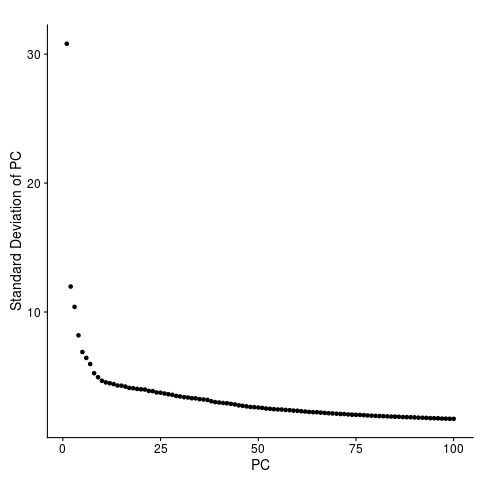

In [16]:
%%R
PCHeatmap(object=testis, pc.use=1:12, cells.use=500, do.balanced=TRUE, label.columns=FALSE, 
          use.full=FALSE)

### Determine statistically significant principal components
PCElbowPlot(object=testis, num.pc=100)

In [17]:
%%R
# NOTE: This process can take a long time for big datasets, comment out for expediency.
# More approximate techniques such as those implemented in PCElbowPlot() can be used to reduce computation time
testis = JackStraw(object=testis, num.replicate=100, do.print=FALSE, num.pc=30)

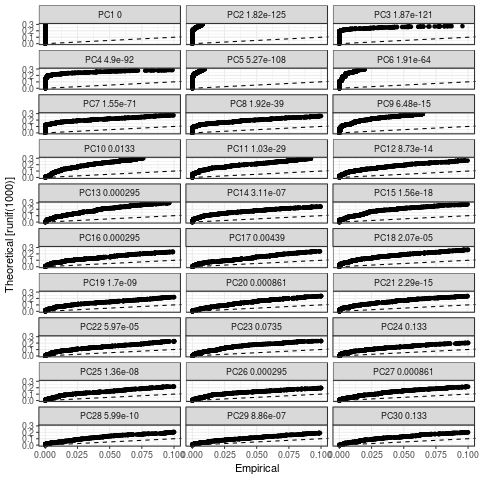

In [18]:
%%R
JackStrawPlot(object=testis, PCs=1:30)

### Cluster the cells
# save.SNN = T saves the SNN so that the clustering algorithm can be rerun using the same graph
# but with a different resolution value (see docs for full details)

Parameters used in latest FindClusters calculation run on: 2017-11-21 11:16:17
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
30



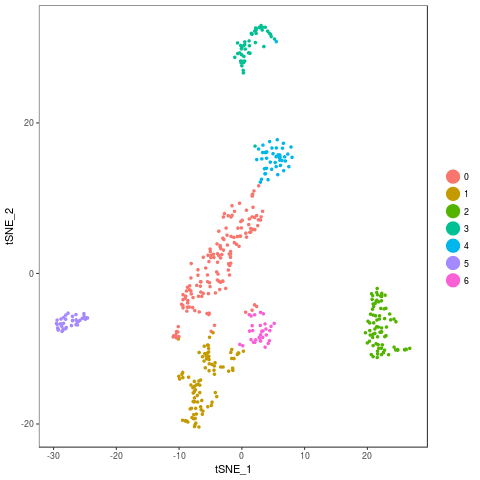

In [87]:
%%R
testis = FindClusters(object=testis, reduction.type="pca", dims.use=1:30, 
                      resolution=0.6, print.output=0, save.SNN=TRUE)

PrintFindClustersParams(object=testis)
# While we do provide function-specific printing functions, the more general function to
# print calculation parameters is PrintCalcParams().

### Run Non-linear dimensional reduction (tSNE)
testis = RunTSNE(object=testis, dims.use=1:30, do.fast=TRUE)
# note that you can set do.label=T to help label individual clusters
TSNEPlot(object=testis)
#save(testis, file = "../../output/testis_seurat.Robj")

In [88]:
%%R
### Finding differentially expressed genes (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
testis.markers = FindAllMarkers(object=testis, only.pos=TRUE, 
                                min.pct=0.25, thresh.use=0.25)
testis.markers %>% group_by(cluster) %>% top_n(2, avg_diff)

   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 44s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 29s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 46s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 01m 30s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 02m 01s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 55s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 41s
Error in filter_impl(.data, dots) : object 'avg_diff' not found


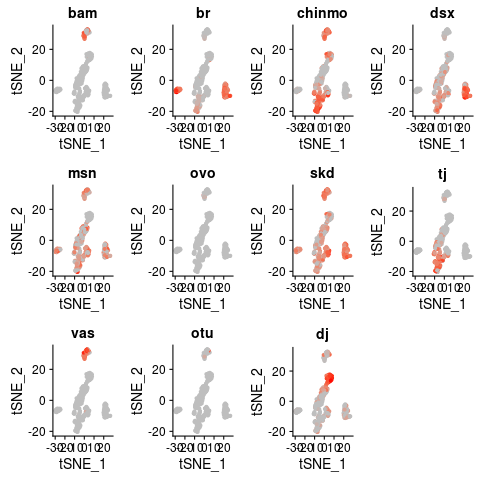

In [89]:
%%R
merged = left_join(testis.markers, fbgn.symbol, by=c('gene' = 'FBgn'))
#write.table(merged[, c('gene', 'symbol', 'cluster', 'p_val', 'avg_diff', 'pct.1', 'pct.2')], file="../../output/testis_preliminary_analysis_biomarkers.tsv", quote=FALSE, sep="\t", row.names=FALSE, col.names=TRUE)

# I have tried the following but they were not in the dataset
## en
genes = c(
          "bam",
          "br",
          "chinmo",
          "dsx",
          "msn",
          "ovo",
          "skd",
          "tj",
          "vas",
          "otu",
          "dj"
          )
FeaturePlot(object=testis, features.plot=genes, cols.use=c('grey', 'red'), 
            pt.size=2, pch.use = 20, reduction.use='tsne')